In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
import tensorboard as tb

%load_ext autoreload
%autoreload 2

This notebook reads in the results of the deep learning HPO and visualizes the result

In [3]:
from tensorflow.python.summary.summary_iterator import summary_iterator

In [ ]:
from glob import glob
# event_files = glob('../../logs_ray_torch/ExtensiveHPO_seqconv/seqconv/**/events.out*', recursive=True)

def argsort(seq):
    return sorted(range(len(seq)), key=seq.__getitem__)

hist_glob_path = ''
def get_val_loss_hists(path):
    event_files_all = glob(path, recursive=True)
    used_event_files = []
    val_loss_hists = []
    N_hists = len(event_files_all)
    print(N_hists)
    for i,f in enumerate(event_files_all):
        val_losses = []
        for e in summary_iterator(f):
            for v in e.summary.value:
                if 'val_loss' in v.tag:
                    val_losses.append(v.simple_value)
        if len(val_losses) > 0:
            val_loss_hists.append(val_losses)
            used_event_files.append(f)
    
    # filter_idx = [i for i,loss_hist in enumerate(val_loss_hists) if max(loss_hist) > 0.8]
    filter_idx = [i for i,loss_hist in enumerate(val_loss_hists) if loss_hist[-1] > 0.8]
    print(filter_idx)
    N_hists -= len(filter_idx)
    val_loss_hists, used_event_files = zip(*[[loss_hist,event_file] for i,(loss_hist,event_file) in enumerate(zip(val_loss_hists, used_event_files)) if i not in filter_idx])
    sorted_idx = argsort([loss_hist[-1] for loss_hist in val_loss_hists])
    # val_loss_hists = sorted(val_loss_hists, key=lambda l:l[-1])
    val_loss_hists = [val_loss_hists[i] for i in sorted_idx]
    used_event_files = [used_event_files[i] for i in sorted_idx]

    val_loss_hists_np = np.full((N_hists,100), np.nan)
    for i,val_loss_hist in enumerate(val_loss_hists):
        val_loss_hists_np[i,:len(val_loss_hist)] = val_loss_hist

    return val_loss_hists_np, used_event_files

val_loss_hists_seq, evfiles_seq = get_val_loss_hists(f'{path_base}/seq/**/events.out*')
val_loss_hists_seqconv, evfiles_seqconv = get_val_loss_hists(f'{path_base}/seqconv/**/events.out*')
val_loss_hists_resdnn, evfiles_resdnn = get_val_loss_hists(f'{path_base}/resdnn/**/events.out*')
val_loss_hists_unet, evfiles_unet = get_val_loss_hists(f'{path_base}/unet/**/events.out*')

In [4]:

data = np.load('../logs_ray_torch-ExtensiveHPOAggregated.npz')

val_loss_hists_seq = data['val_loss_hists_seq']
evfiles_seq = data['evfiles_seq']
val_loss_hists_seqconv = data['val_loss_hists_seqconv']
evfiles_seqconv = data['evfiles_seqconv']
val_loss_hists_resdnn = data['val_loss_hists_resdnn']
evfiles_resdnn = data['evfiles_resdnn']
val_loss_hists_unet = data['val_loss_hists_unet']
evfiles_unet = data['evfiles_unet']

In [5]:
def cat(file):
    with open(file, 'r') as f:
        for line in f.readlines():
            print(line, end='')

In [7]:
min_len = min([len(val_loss_hists_seq), len(val_loss_hists_seqconv), len(val_loss_hists_resdnn), len(val_loss_hists_unet)])
npr.seed(42)
rnd_idx = npr.choice(min_len)
val_loss_hists_seq = val_loss_hists_seq[npr.choice(len(val_loss_hists_seq), min_len, replace=False)]
val_loss_hists_seqconv = val_loss_hists_seqconv[npr.choice(len(val_loss_hists_seqconv), min_len, replace=False)]
val_loss_hists_resdnn = val_loss_hists_resdnn[npr.choice(len(val_loss_hists_resdnn), min_len, replace=False)]
val_loss_hists_unet = val_loss_hists_unet[npr.choice(len(val_loss_hists_unet), min_len, replace=False)]

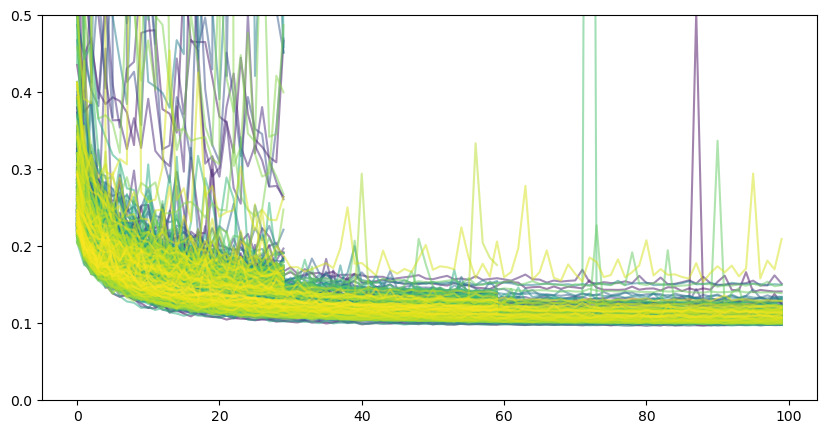

In [8]:
%matplotlib inline
plt.figure(figsize=(10,5))
cmap = plt.get_cmap('viridis')
val_loss_hists_plot = val_loss_hists_unet
for i,val_loss_hist in enumerate(val_loss_hists_plot):
    # plt.plot(val_loss_hist, color='green')
    plt.plot(val_loss_hist, color=cmap(i/len(val_loss_hists_plot)), alpha=0.5)
plt.ylim(0, 0.5)
plt.show()

In [9]:
min_loss_seq_negl = np.nanmin(val_loss_hists_seq)
min_loss_seqconv_negl = np.nanmin(val_loss_hists_seqconv)
min_loss_resdnn_negl = np.nanmin(val_loss_hists_resdnn)
min_loss_unet_negl = np.nanmin(val_loss_hists_unet)

In [10]:
min_loss_seq = np.nanmin(val_loss_hists_seq)
min_loss_seqconv = np.nanmin(val_loss_hists_seqconv)
min_loss_resdnn = np.nanmin(val_loss_hists_resdnn)
min_loss_unet = np.nanmin(val_loss_hists_unet)
print(min_loss_seq)
print(min_loss_seqconv)
print(min_loss_resdnn)
print(min_loss_unet)

0.10737156122922897
0.11114220321178436
0.10326957702636719
0.09663476794958115


In [11]:
print((min_loss_seq_negl-min_loss_seq)/min_loss_seq) # = 0.0015632553769984812
print((min_loss_seqconv_negl-min_loss_seqconv)/min_loss_seqconv)  # = 0.04855851250492217
print((min_loss_resdnn_negl-min_loss_resdnn)/min_loss_resdnn) # = 0.041508720900882874
print((min_loss_unet_negl-min_loss_unet)/min_loss_unet) # = 0.03272348836339741

0.0
0.0
0.0
0.0


In [12]:
cmaps = [plt.get_cmap(color) for color in ['Blues','Greens','Oranges','Purples']]
colors = ['blue','green','orange','purple']
val_loss_hists_lists = [val_loss_hists_seq, val_loss_hists_seqconv, val_loss_hists_resdnn, val_loss_hists_unet]
model_names = ['MLP','CNN','ResNet','U-Net']
hatches = ['.','\\','o','/']
rounded_min_losses = [np.round(min_loss_seq,3),np.round(min_loss_seqconv,3),np.round(min_loss_resdnn,3),np.round(min_loss_unet,3)]

In [13]:
def format_tex_float(x):
    base = int(np.floor(np.log10(x)))
    mul = x/10**base
    
    return rf'${round(mul)}\cdot 10^{{{base}}}$'
    
x = 0.7
print(format_tex_float(x))
print(f'{x:2.2e}')

$7\cdot 10^{-1}$
7.00e-01


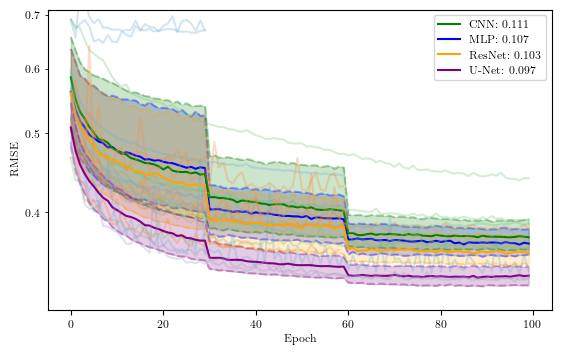

In [14]:
%matplotlib inline
plt.style.use('default')
from convection_param.setup_mpl_tex import set_size, setup_mpl_tex
import matplotlib.ticker as mticker

setup_mpl_tex()

# for seed in [2]:
# seed = 9528
seed = 2
# seed = 90
# seed = 923134

fig, ax = plt.subplots(constrained_layout=True, figsize=set_size('textwidth', ratio=4/6.4))

handles = []
for name,val_loss_hists,cmap,color,hatch in zip(model_names, val_loss_hists_lists, cmaps, colors, hatches):
    val_loss_hists = np.sqrt(val_loss_hists)
    # val_loss_hists = val_loss_hists
    val_loss_hist_mean = np.nanmedian(val_loss_hists, axis=0)
    # val_loss_hist_mean = np.nanmin(val_loss_hists, axis=0)
    # val_loss_hist_std = np.nanstd(val_loss_hists, axis=0)
    val_loss_hist_range_up = np.nanquantile(val_loss_hists, 0.75, axis=0) # val_loss_hist_mean + val_loss_hist_std
    val_loss_hist_range_down = np.nanquantile(val_loss_hists, 0.25, axis=0) # val_loss_hist_mean - val_loss_hist_std

    npr.seed(seed)
    rnd_idx = npr.choice(val_loss_hists.shape[0], 6, replace=False)

    x = np.arange(len(val_loss_hist_mean))
    handle = ax.plot(x, val_loss_hist_mean, color=color, label=name)
    handles.append(handle)
    ax.plot(x, val_loss_hist_range_up, ls='--', alpha=0.3, color=color)
    ax.plot(x, val_loss_hist_range_down, ls='--', alpha=0.3, color=color)
    ax.fill_between(x, val_loss_hist_range_down, val_loss_hist_range_up, alpha=0.2, color=color)#, hatch=hatch)
    for i,rnd_line in enumerate(val_loss_hists[rnd_idx]):
        # ax.plot(x, rnd_line, alpha=0.3, color=cmap(i/10))
        ax.plot(x, rnd_line, alpha=0.3, color=cmap(0.5))

# fullmodel_ylims = (0.3032969264229547, 0.71)
# woqrqsmodel_ylims = (0.3373552477734708, 0.71)
ax.set_ylim(None,0.71)
# ax.set_ylim(woqrqsmodel_ylims)
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
ax.set_yscale('log')

# def y_fmt(x, pos):
#     return format_tex_float(x)
# ax.yaxis.set_minor_formatter(mticker.FuncFormatter(y_fmt))
# ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(mticker.StrMethodFormatter('{x:.1f}'))

# text =\
# f'''Minimum Test Error:
# Conv: {rounded_min_losses[1]}
# Seq: {rounded_min_losses[0]}
# ResDNN: {rounded_min_losses[2]}
# Unet: {rounded_min_losses[3]}'''

handles, _ = ax.get_legend_handles_labels()
labels = [n + f': {l}' for n,l in zip(model_names,rounded_min_losses)]
ax.legend(*list(zip(*[[handles[i], labels[i]] for i in [1,0,2,3]])))
# ax.text(0.5, 0.99, text, transform=ax.transAxes, va='top', ha='left')#, multialignment='center')

# fig.savefig('../../Figures/Pdfplots/test_loss_curves_textwidth.pdf')
# fig.savefig('../../Figures/test_loss_curves_textwidth.jpg', dpi=300)
# fig.savefig('../../Figures/Pgfplots/test_loss_curves_textwidth_new.pdf')
# fig.savefig('../../Figures/Pdfplots/test_loss_curves_woqrqs_rhofluctneglect_samescale_halfa4.pdf')
plt.show()